In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Final Ensemble(LGBM+Bert+LightGCN)

In [2]:
PATH = "output/"                                        # AUROC    ACC
ens1 = pd.read_csv(PATH+"final_best1.csv",index_col=0)
lgbm = pd.read_csv(PATH+"final_best2.csv",index_col=0)

In [3]:
result = (ens1+lgbm)/2

In [4]:
result.describe()

,prediction
count,744.000000
mean,0.495277
std,0.266843
min,0.019610
25%,0.256060
50%,0.484350
75%,0.728215
max,0.971938


In [5]:
result.to_csv(PATH+"final_lgbm50_bert25_lgcn25.csv")

<AxesSubplot:ylabel='Density'>

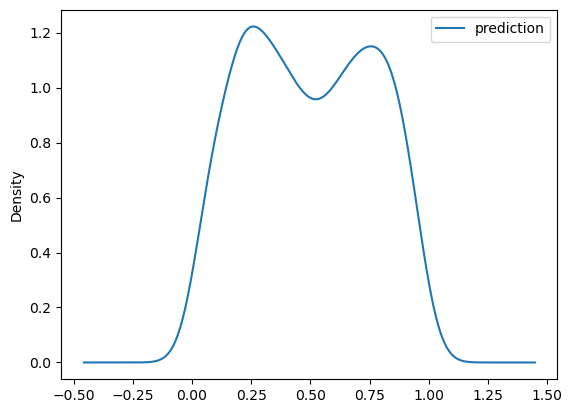

In [6]:
result.plot.density()

array([[<AxesSubplot:title={'center':'prediction'}>]], dtype=object)

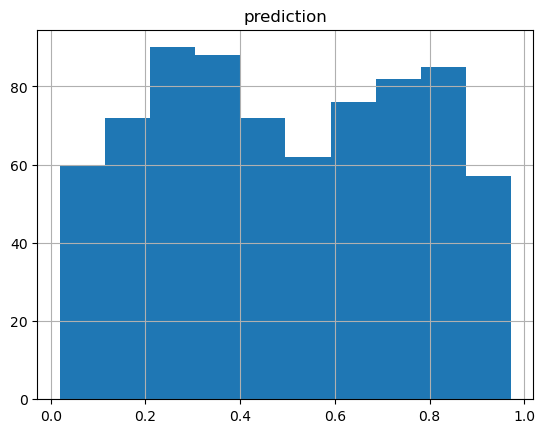

In [7]:
result.hist()

In [8]:
PATH = "output/"                                        # AUROC    ACC
bert = pd.read_csv(PATH+"bert_best.csv",index_col=0)    # 0.8093	0.7446
saint = pd.read_csv(PATH+"saint_best.csv",index_col=0)  # 0.7997	0.7339
lgcn = pd.read_csv(PATH+"lightgcn_best.csv",index_col=0)# 0.7934	0.7043
tab = pd.read_csv(PATH+"tabnet_best.csv",index_col=0)   # 0.7891	0.7097
lstm = pd.read_csv(PATH+"lstmattn_best.csv",index_col=0)# 0.7823	0.7124
lgbm = pd.read_csv(PATH+"lgbm_best.csv",index_col=0)

# Tree Ensemble

In [9]:
def tree_ensemble(outputs: list, min_threshold=0.2, max_threshold=0.8):
    result = pd.DataFrame({"prediction":[0]*744})
    result.index.name = "id"
    level = 0
    undecided = set([i for i in range(744)])
    for output in outputs:
        min_indices = set(output[(output['prediction'] < min_threshold)].index.unique())
        max_indices = set(output[(output['prediction'] > max_threshold)].index.unique())
        tmp_indices = min_indices.union(max_indices)
        indices = undecided&tmp_indices
        undecided = undecided-tmp_indices
        min_indices = list(indices&min_indices)
        max_indices = list(indices&max_indices)
        result.loc[min_indices] = (output.loc[min_indices] + (min_threshold+0.1) * level) / (level + 1)
        result.loc[max_indices] = (output.loc[max_indices] + (max_threshold-0.1) * level) / (level + 1)
        print(f"[{level} LEVEL] {len(indices):3d} 개 결정, {len(undecided):3d} 개 남음")
        level += 1

    print(f"744개 중 {744-len(undecided):3d} 개 확정, 남은 불확실 요소 {len(undecided):3d} 개 {len(undecided)/7.44}% 남음")
    # [TODO] 남은 애들 평균으로 처리
    undecided = list(undecided)
    for output in outputs:
        result.loc[undecided] += output.loc[undecided] / len(outputs)

    return result

In [11]:
outputs = [bert,saint,lgcn,tab,lstm]
ens_result = tree_ensemble(outputs)

[0 LEVEL] 299 개 결정, 445 개 남음
[1 LEVEL]  57 개 결정, 388 개 남음
[2 LEVEL]  70 개 결정, 318 개 남음
[3 LEVEL]  68 개 결정, 250 개 남음
[4 LEVEL]  42 개 결정, 208 개 남음
744개 중 536 개 확정, 남은 불확실 요소 208 개 27.956989247311828% 남음


In [157]:
ens_result.to_csv("./output/tree_ensemble.csv")

array([[<AxesSubplot:title={'center':'prediction'}>]], dtype=object)

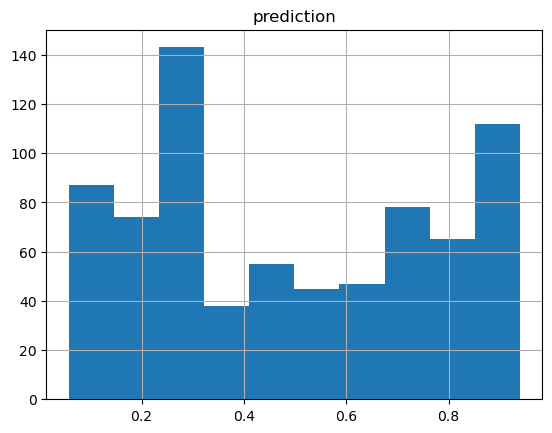

In [12]:
ens_result.hist()

<AxesSubplot:ylabel='Density'>

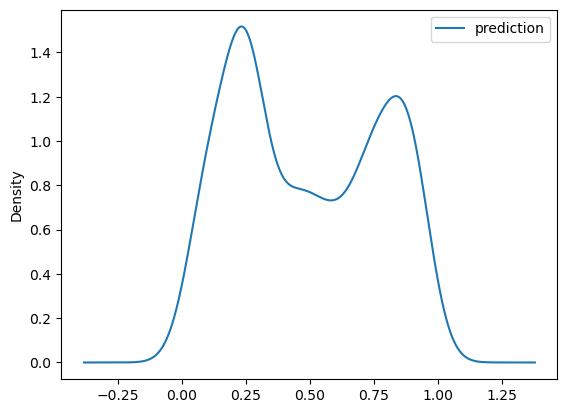

In [13]:
ens_result.plot.density()

# Voting Ensemble

In [14]:
bert = pd.read_csv(PATH+"bert_best.csv",index_col=0)    # 0.8093	0.7446
saint = pd.read_csv(PATH+"saint_best.csv",index_col=0)  # 0.7997	0.7339
lgcn = pd.read_csv(PATH+"lightgcn_best.csv",index_col=0)# 0.7934	0.7043
tab = pd.read_csv(PATH+"tabnet_best.csv",index_col=0)   # 0.7891	0.7097
#cat = pd.read_csv(PATH+"lstmattn_best.csv",index_col=0) # 0.7715    0.7043
lstm = pd.read_csv(PATH+"lstmattn_best.csv",index_col=0)# 0.7823	0.7124

In [15]:
def voting_ensemble(outputs:np.ndarray):
    n = len(outputs)
    threshold = n/2
    result = pd.DataFrame({"prediction":[0]*744})
    result.index.name = "id"
    for i in range(744):
        votes = np.array([False]*n)
        for j in range(n):
            if outputs[j][i] > 0.5:
                votes[j] = True
        if sum(votes) > threshold:
            result.loc[i] = outputs[votes,i].mean()
        else:
            result.loc[i] = outputs[~votes,i].mean()
    return result

In [16]:
outputs = np.array([bert,saint,lgcn,tab,lstm])

In [17]:
vote_ens = voting_ensemble(outputs)

array([[<AxesSubplot:title={'center':'prediction'}>]], dtype=object)

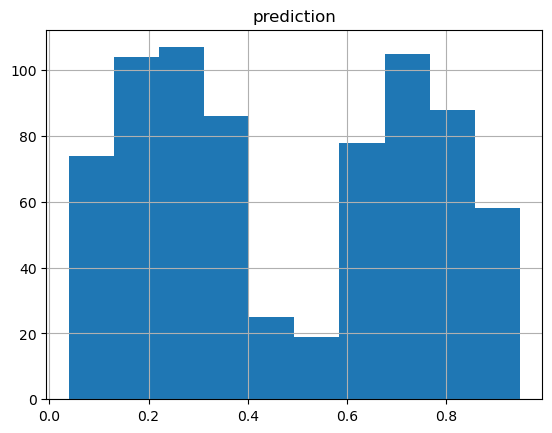

In [18]:
vote_ens.hist()

<AxesSubplot:ylabel='Density'>

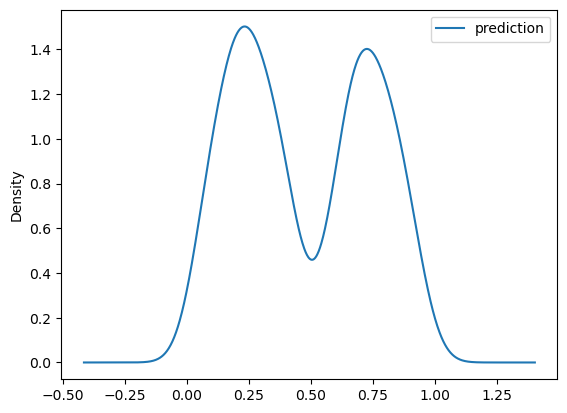

In [20]:
vote_ens.plot.density()

In [75]:
vote_ens.to_csv(PATH+"bert_saint_lgcn_tab_lstmattn_vote.csv")